# 신용카드 디폴트 찾기

# 데이터
- 2005년 대만은행 제공
- 대출 총액(limit_bill), 과거 상환 내역등을 보고 다음달 디폴트 예측
- 이전 6개월의 상환 상태 (payment status): PAY
- 이전 6개월의 청구 금액 (bill statement): BILL_AMT
- 이전 6개월의 상환 현황 (previous payment): PAY_AMT

## import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.figsize'] = [8, 6]

In [3]:
!curl -o default.xls https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5409k  100 5409k    0     0  1920k      0  0:00:02  0:00:02 --:--:-- 1920k


In [4]:
df = pd.read_excel('default.xls', skiprows=1, index_col=0)
print(df.shape)
df[:3]

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


## 컬럼명 정리
- 대소문자, 띄어쓰기 처리

In [5]:
df.columns.str.lower().str.replace(" ", "_")

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')

In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df[:3].T

ID,1,2,3
limit_bal,20000,120000,90000
sex,2,2,2
education,2,2,2
marriage,1,2,2
age,24,26,34
pay_0,2,-1,0
pay_2,2,2,0
pay_3,-1,0,0
pay_4,-1,0,0
pay_5,-2,0,0


In [7]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
variables = ['payment_status', 'bill_statement', 'previous_payment']
new_column_names = [x + '_' + y for x in variables for y in months]
new_column_names

['payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

In [8]:
rename_dict = {x: y for x, y in zip(df.loc[:, 'pay_0':'pay_amt6'].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)
df.head().T

ID,1,2,3,4,5
limit_bal,20000,120000,90000,50000,50000
sex,2,2,2,2,1
education,2,2,2,2,2
marriage,1,2,2,1,1
age,24,26,34,37,57
payment_status_sep,2,-1,0,0,-1
payment_status_aug,2,2,0,0,0
payment_status_jul,-1,0,0,0,-1
payment_status_jun,-1,0,0,0,0
payment_status_may,-2,0,0,0,0


## 카테고리 변수 처리

In [9]:
# 알려져 있는 인코딩 값을 카테고리 변수로 표현 (숫자--> 문자열)
gender_dict = {1: 'Male', 
               2: 'Female'}
education_dict = {0: 'Others',
                  1: 'Graduate school', 
                  2: 'University', 
                  3: 'High school', 
                  4: 'Others',
                  5: 'Others',
                  6: 'Others'}
marital_status_dict = {0: 'Others', 
                       1: 'Married', 
                       2: 'Single', 
                       3: 'Others'}
payment_status = {-2: 'Unknown',
                  -1: 'Payed duly',
                  0: 'Unknown',
                  1: 'Payment delayed 1 month',
                  2: 'Payment delayed 2 months',
                  3: 'Payment delayed 3 months',
                  4: 'Payment delayed 4 months',
                  5: 'Payment delayed 5 months',
                  6: 'Payment delayed 6 months',
                  7: 'Payment delayed 7 months',
                  8: 'Payment delayed 8 months',
                  9: 'Payment delayed >= 9 months'}

# 숫자로된 인코딩을 문자열로 변환
df.sex = df.sex.map(gender_dict)
df.education = df.education.map(education_dict)
df.marriage = df.marriage.map(marital_status_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  int64 
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  int64 
 5   payment_status_sep          30000 non-null  int64 
 6   payment_status_aug          30000 non-null  int64 
 7   payment_status_jul          30000 non-null  int64 
 8   payment_status_jun          30000 non-null  int64 
 9   payment_status_may          30000 non-null  int64 
 10  payment_status_apr          30000 non-null  int64 
 11  bill_statement_sep          30000 non-null  int64 
 12  bill_statement_aug          30000 non-null  int64 
 13  bill_statement_jul          30000 non-null  in

In [10]:
for column in [x for x in df.columns if ('status' in x)]:
    df[column] = df[column].map(payment_status)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  int64 
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  int64 
 5   payment_status_sep          30000 non-null  object
 6   payment_status_aug          30000 non-null  object
 7   payment_status_jul          30000 non-null  object
 8   payment_status_jun          30000 non-null  object
 9   payment_status_may          30000 non-null  object
 10  payment_status_apr          30000 non-null  object
 11  bill_statement_sep          30000 non-null  int64 
 12  bill_statement_aug          30000 non-null  int64 
 13  bill_statement_jul          30000 non-null  in

In [11]:
df[:3].T

ID,1,2,3
limit_bal,20000,120000,90000
sex,Female,Female,Female
education,University,University,University
marriage,Married,Single,Single
age,24,26,34
payment_status_sep,Payment delayed 2 months,Payed duly,Unknown
payment_status_aug,Payment delayed 2 months,Payment delayed 2 months,Unknown
payment_status_jul,Payed duly,Unknown,Unknown
payment_status_jun,Payed duly,Unknown,Unknown
payment_status_may,Unknown,Unknown,Unknown


## 특성 추출

In [12]:
df_raw = df.copy()

In [13]:
X = df.copy()
y = X.pop('default_payment_next_month')

In [14]:
cat_features = X.select_dtypes(include='object').columns.to_list()
cat_features

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

In [15]:
cont_features = X.select_dtypes(include=['int', 'float']).columns.to_list()
cont_features

['limit_bal',
 'age',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

### 카테고리 인코딩

In [16]:
X_cat = pd.get_dummies(X, columns=cat_features)
X_cat.shape

(30000, 81)

### 로그변환

<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

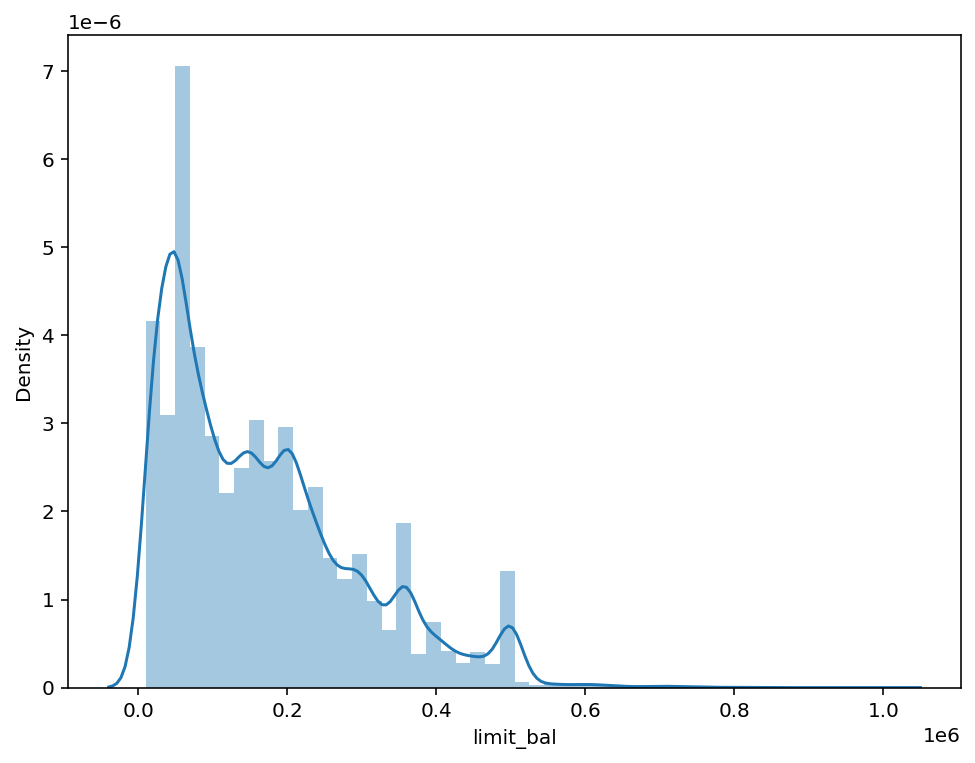

In [17]:
sns.distplot(X_cat.limit_bal)

<AxesSubplot:xlabel='limit_bal', ylabel='Density'>

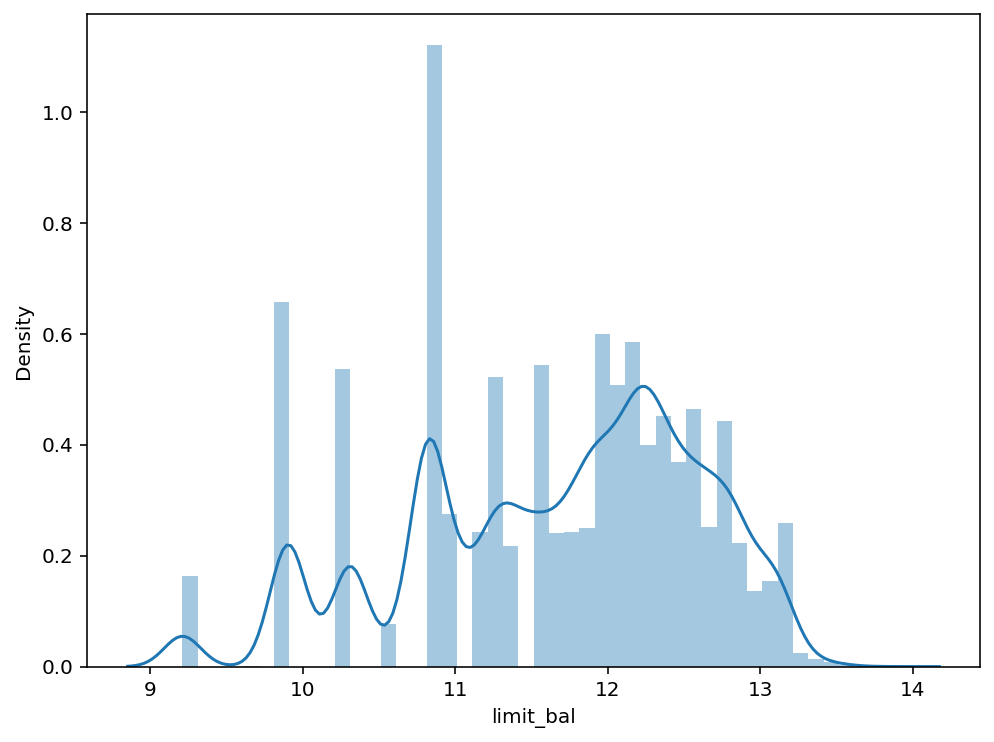

In [18]:
sns.distplot(np.log(X_cat.limit_bal))

In [20]:
X_cat.limit_bal = np.log(X_cat.limit_bal)
X_cat[:3]

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,payment_status_may_Unknown,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 8 months,payment_status_apr_Unknown
ID,,,,,,,,,,,,,,,,,,,,,
1,2.292887,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,1
2,2.459183,26,2682,1725,2682,3272,3455,3261,0,1000,...,1,0,1,0,0,0,0,0,0,0
3,2.434277,34,29239,14027,13559,14331,14948,15549,1518,1500,...,1,0,0,0,0,0,0,0,0,1


## 모델 성능 비교

In [24]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

- 스케일링 하지 않은 데이터 사용

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y)

In [26]:
from lightgbm import LGBMClassifier

In [27]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, early_stopping_rounds=5, eval_set=(X_test, y_test), verbose=False)
y_pred = lgbm.predict(X_test)
show_clf_result(y_test, y_pred)

[[5529  317]
 [1057  597]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5846
           1       0.65      0.36      0.46      1654

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [28]:
proba_1 = lgbm.predict_proba(X_test)[:,1]

In [29]:
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

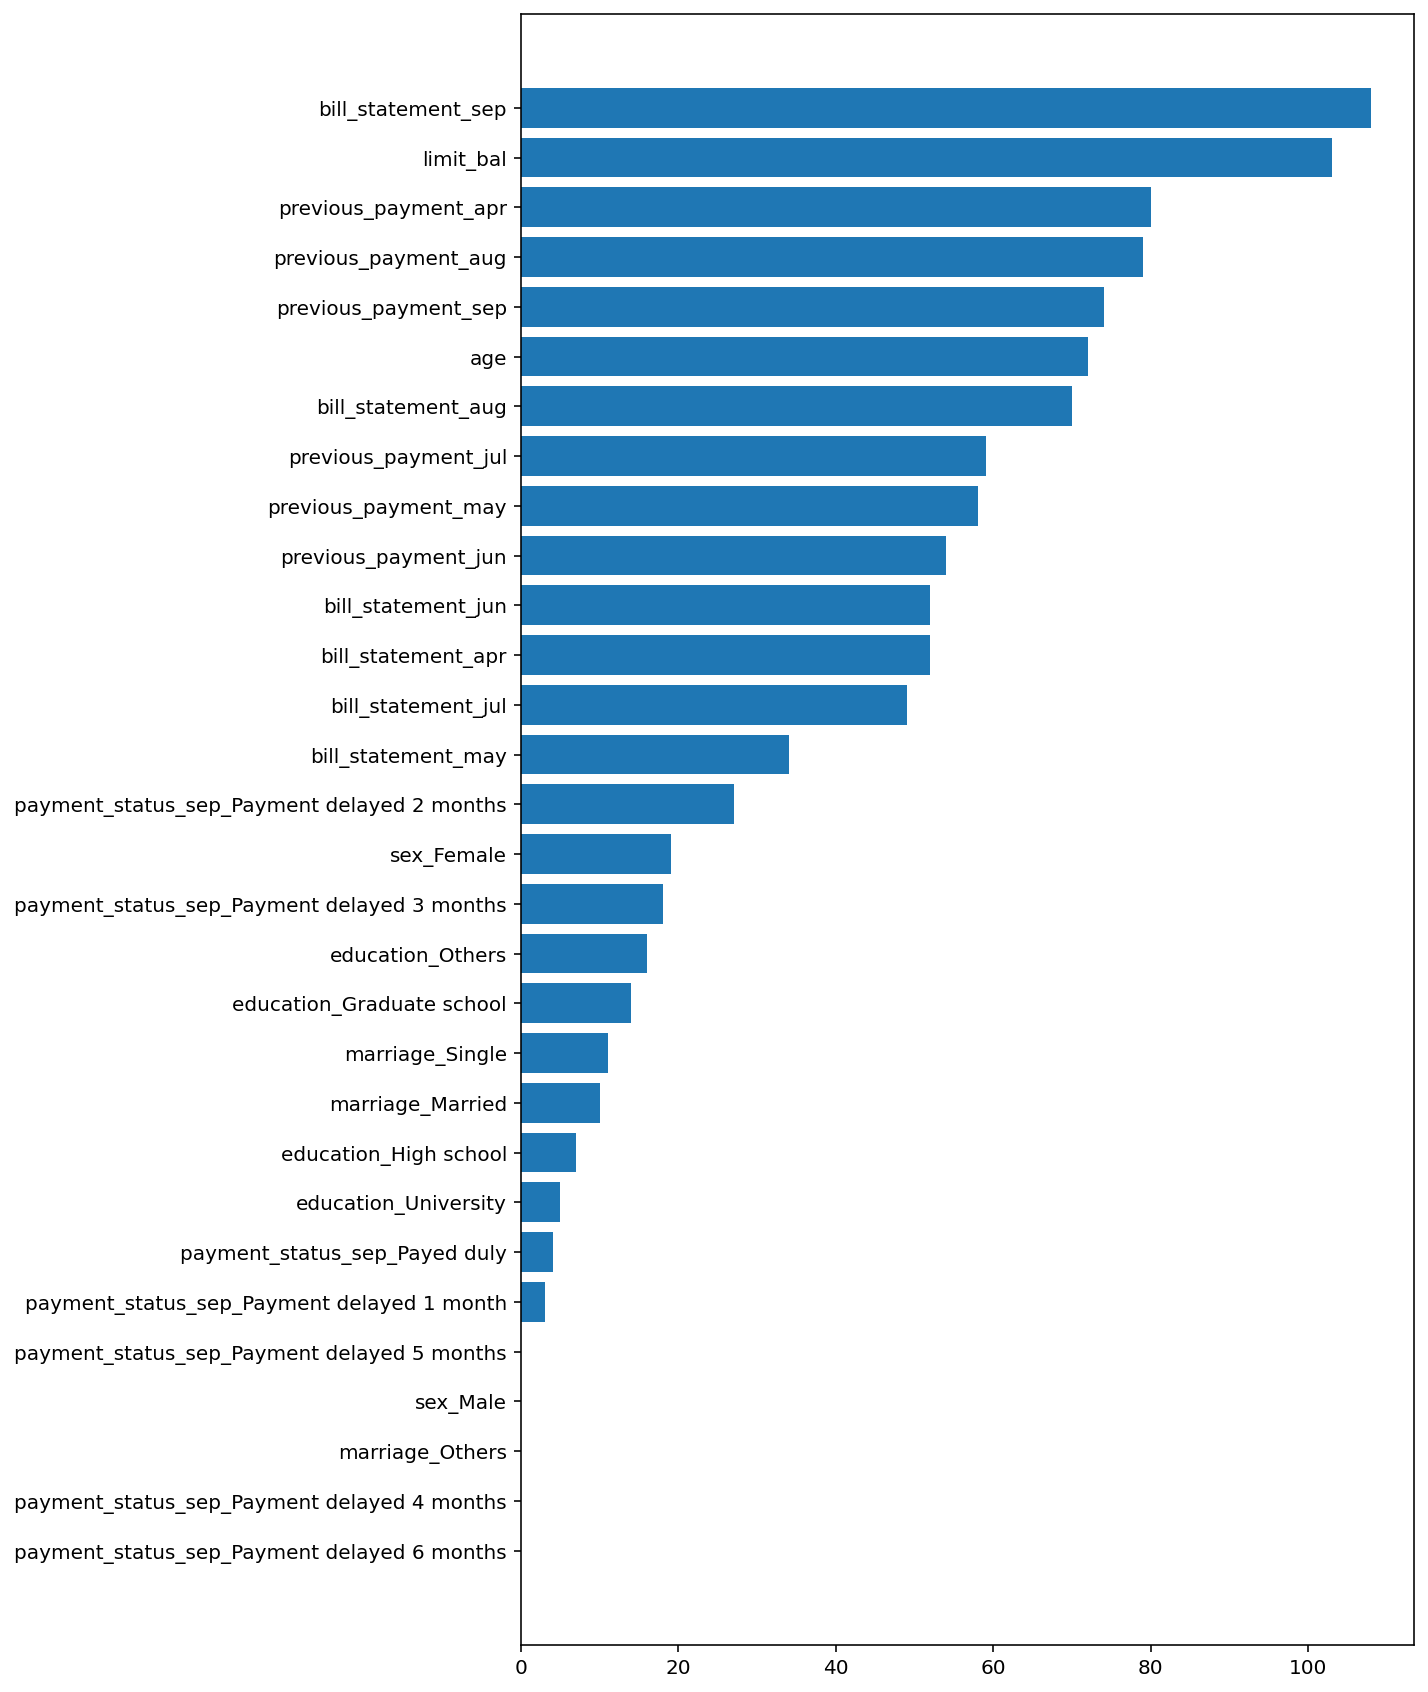

In [30]:
plot_feature_weight(X_cat.columns, lgbm.feature_importances_, 30)

## (연습) 디폴트 가능성이 가장 높은 사람 10명을 찾으시오
- ID, 나이, limit_bal 값을 확인하시오

In [31]:
X_test2 = X_test.copy()
X_test2['proba_1'] = proba_1
default_id = X_test2.sort_values('proba_1', ascending=False)[:10].index.tolist()
default_id

[16555, 17248, 17034, 22760, 17863, 24346, 21013, 16040, 17875, 7789]

## (연습) 디폴트를 찾는 리콜이 0.95 이상이 되는 예측 모델을 만드시오

In [32]:
y_pred_high_recall = proba_1 > 0.08
show_clf_result(y_test, y_pred_high_recall)

[[1370 4476]
 [  83 1571]]
              precision    recall  f1-score   support

           0       0.94      0.23      0.38      5846
           1       0.26      0.95      0.41      1654

    accuracy                           0.39      7500
   macro avg       0.60      0.59      0.39      7500
weighted avg       0.79      0.39      0.38      7500



In [64]:
X_cat.shape

(30000, 81)

## 특성중요도 선택

In [33]:
W = pd.DataFrame({'feature':X_cat.columns,'weight':lgbm.feature_importances_})
W.sort_values('weight', inplace=True, ascending=False)
W

,feature,weight
2,bill_statement_sep,108
0,limit_bal,103
13,previous_payment_apr,80
9,previous_payment_aug,79
8,previous_payment_sep,74
...,...,...
58,payment_status_jun_Payment delayed 5 months,0
59,payment_status_jun_Payment delayed 6 months,0
60,payment_status_jun_Payment delayed 7 months,0
61,payment_status_jun_Payment delayed 8 months,0


In [39]:
features = W.feature[:20].values.tolist()
features

['bill_statement_sep',
 'limit_bal',
 'previous_payment_apr',
 'previous_payment_aug',
 'previous_payment_sep',
 'age',
 'bill_statement_aug',
 'previous_payment_jul',
 'previous_payment_may',
 'previous_payment_jun',
 'bill_statement_apr',
 'bill_statement_jun',
 'bill_statement_jul',
 'bill_statement_may',
 'payment_status_sep_Payment delayed 2 months',
 'payment_status_jun_Payment delayed 2 months',
 'payment_status_sep_Unknown',
 'payment_status_may_Payment delayed 2 months',
 'sex_Female',
 'payment_status_apr_Payment delayed 2 months']

In [40]:
X_10 = X_cat.copy()[features]
X_10.shape

(30000, 20)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_10, y)

lgbm.fit(X_train, y_train, early_stopping_rounds=5, eval_set=(X_test, y_test), verbose=False)
y_pred = lgbm.predict(X_test)
show_clf_result(y_test, y_pred)

[[5527  315]
 [1026  632]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5842
           1       0.67      0.38      0.49      1658

    accuracy                           0.82      7500
   macro avg       0.76      0.66      0.69      7500
weighted avg       0.80      0.82      0.80      7500



In [42]:
proba_1 = lgbm.predict_proba(X_test)[:,1]

In [43]:
X_test2 = X_test.copy()
X_test2['proba_1'] = proba_1
default_id_20 = X_test2.sort_values('proba_1', ascending=False)[:10].index.tolist()
default_id_20

[8773, 16933, 26606, 4337, 7789, 13407, 14245, 10804, 17847, 8468]

In [44]:
len(set(default_id_20) & set(default_id))

1

In [45]:
set(default_id_20) & set(default_id)

{7789}